# Problem statement

*Context*: Twitter is a microblogging and social networking service on which users post and interact with messages known as "tweets". Every second, on average, around 6,000 tweets are tweeted on Twitter, corresponding to over 350,000 tweets sent per minute, 500 million tweets per day.
Twitter wants to automatically tag and analyze tweets for better understanding of the trends and topics without being dependent on the hashtags that the users use. Many users do not use hashtags or sometimes use wrong or mis-spelled tags, so they want to completely remove this problem and create a system of recognizing important content of the tweets.

*Objective*: You need to train a model that will be able to identify the various named entities.


## Downloading data

## Installing libraries

In [2]:
%pip install datasets

!pip install tensorflow==2.9.0
!pip install tensorflow-addons==0.19.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
    

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.6 MB/s eta 0:00:00


In [1]:
import pandas as pd
import tensorflow as tf

## Loading data from the files

In [2]:
def load_data(filename: str):
  # Conll file is stored as (token, tag) pairs, one per line
  # Extracting data from conll files
  with open(filename, 'r',encoding='utf-8') as file:
    lines = [line[:-1].split() for line in file] # Skipping last line as it will be a blank space
  samples, start = [], 0
  for end, parts in enumerate(lines):
      if not parts:
          sample = [(token, tag)
                      for token, tag in lines[start:end]]
          samples.append(sample)
          start = end + 1
  if start < end:
    samples.append(lines[start:end])
  return samples

train_samples = load_data('wnut 16.txt.conll')
test_samples = load_data('wnut 16test.txt.conll')
samples = train_samples + test_samples
schema = ['_'] + sorted({tag for sentence in samples
                             for _, tag in sentence}) # '_' is used to indicate a null (blank) token.

## Structure of data

In [3]:
train_samples[1]

[('Made', 'O'),
 ('it', 'O'),
 ('back', 'O'),
 ('home', 'O'),
 ('to', 'O'),
 ('GA', 'B-geo-loc'),
 ('.', 'O'),
 ('It', 'O'),
 ('sucks', 'O'),
 ('not', 'O'),
 ('to', 'O'),
 ('be', 'O'),
 ('at', 'O'),
 ('Disney', 'B-facility'),
 ('world', 'I-facility'),
 (',', 'O'),
 ('but', 'O'),
 ('its', 'O'),
 ('good', 'O'),
 ('to', 'O'),
 ('be', 'O'),
 ('home', 'O'),
 ('.', 'O'),
 ('Time', 'O'),
 ('to', 'O'),
 ('start', 'O'),
 ('planning', 'O'),
 ('the', 'O'),
 ('next', 'O'),
 ('Disney', 'B-facility'),
 ('World', 'I-facility'),
 ('trip', 'O'),
 ('.', 'O')]

## EDA: Let's have a look at the distribution of tags on data

<Axes: xlabel='keys'>

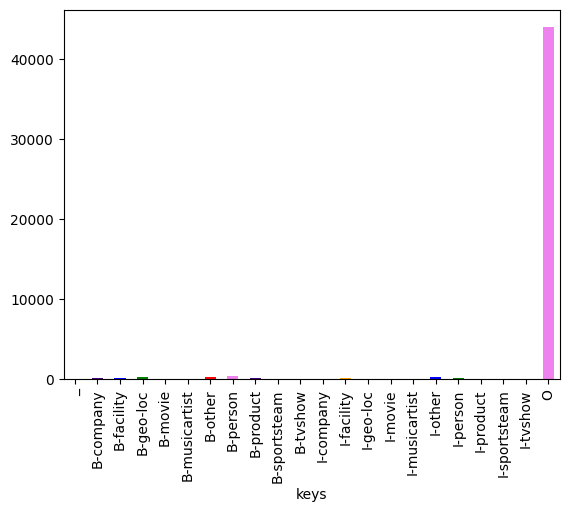

In [4]:
import seaborn as sns
colors = ['violet', 'indigo', 'blue', 'green', 'yellow', 'orange', 'red']
counts = {}

# Calculateing the number of data points having a given label
for tag in schema:
  counts[tag] = 0
  for sample in train_samples:
    for label in sample:
      if label[1] == tag:
        counts[tag]+=1

counts_df = pd.DataFrame({'keys': list(counts.keys()), 'values': list(counts.values())})
counts_df.plot.bar(x='keys', y='values', legend=False, color=colors)

- We have too many "other" fields, which is natural as only few annotations exist per sentence
- let's remove `O` tag and see tag distribution

<Axes: xlabel='keys'>

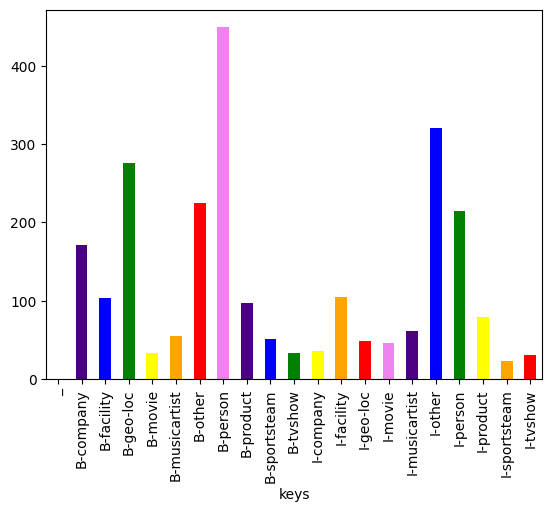

In [5]:
counts.pop('O')
counts_df = pd.DataFrame({'keys': list(counts.keys()), 'values': list(counts.values())})
counts_df.plot.bar(x='keys', y='values', legend=False, color=colors)

## Tag information
- B-* Start token for a tag
- I-* Continuation tokens for a tag

## Available Entities
- Company
- Facility
- Geo-loc: geolocation
- Musicartist
- Person
- Product
- Sportsteam
- TV Show
- Other

### More preprocessing

- let's get vocab & sequence lengths

In [6]:
from collections import defaultdict
all_samples = train_samples
all_samples.extend(test_samples)

word_counts = defaultdict(int) # Calculate vocab size
max_len = 0 # Calculate max length of a sentence

for sample in all_samples:
  for word in sample:
    word_counts[word[0]]+=1

  max_len = max(max_len, len(sample))

n_words = len(word_counts.items())


print("*"*30)
print("Max Length: ", max_len)
print("Vocab Size: ", n_words)

******************************
Max Length:  39
Vocab Size:  25382


## Our approach
- Train a simple LSTM + CRF model to get a baseline
- Look at the results of transformer based architectures

## Training LSTM + CRF model:
- Let's using glove to initialize embeddings

In [7]:
import gensim.downloader as api
word2vec = api.load("glove-twitter-200") # Loading word2vec gensim model
embedding_dim = 200

### Training a tokenizer for LSTM input embeddings

In [8]:
all_sentences = [] # Concating test, train sentences. To train a tokenizer
for sample in all_samples:
  sentence = [tag[0] for tag in sample]
  all_sentences.append(sentence)

crf_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=n_words, lower=True)
crf_tokenizer.fit_on_texts(all_sentences)

### Prepare embedding matrix

In [9]:
import numpy as np
num_tokens = len(crf_tokenizer.word_index) + 1
hits = 0
misses = 0
missed_words = []


# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in crf_tokenizer.word_index.items():
  embedding_vector = None
  try:
    embedding_vector = word2vec[word]
  except Exception :
    pass

  if embedding_vector is not None:
    # Words not found in embedding index will be all-zeros.
    # This includes the representation for "padding" and "OOV"
    embedding_matrix[i] = embedding_vector
    hits += 1
  else:
    missed_words.append(word)
    misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 11495 words (10438 misses)


# LSTM + CRF Model training

## Creating a training dataset

In [10]:
tag2id = {} # Label to indicies mapping
id2tag = {} # Index to label mapping
for i, tag in enumerate(schema):
  tag2id[tag] = i
  id2tag[i] = tag

- We will encode our labels as OHE vectors. This is to keep it compatible with SigmoidFocalCrossEntropy loss

In [11]:
def get_dataset(samples, max_len, tag2id, tokenizer):
  '''Prepares the input dataset

  Args:
    `samples`: List[List[Tuple[word, tag]]], input data
    `max_len`: Maximum input length
    `tag2id`: Mapping[tag: integer]
    `tokenizer`: Tensorflow tokenizer, for tokenizing input sequence

  Returns:
    Tuple[np.ndarray, np.ndarray]: sentences and it's labels
  '''
  dataset = {'samples':[], 'labels': []}

  for sample in samples:
    # Extracting inputs and labels
    inputs = [x[0] for x in sample]
    outputs = [x[1] for x in sample]

    # Tokenizing inputs
    inputs = tokenizer.texts_to_sequences([inputs])[0]

    # padding labels
    padded_inputs = [inputs[i] if i < len(inputs) else 0 for i in range(max_len)]

    # Initializing labels as One Hot Encoded Vectors
    padded_labels = [[0 for i in range(len(tag2id))] for j in range(max_len)]
    for i in range(len(outputs)):
      padded_labels[i][tag2id[outputs[i]]] = 1

    # Adding padded inputs & labels to dataset
    dataset['samples'].append(padded_inputs)
    dataset['labels'].append(padded_labels)

  return np.array(dataset['samples']), np.array(dataset['labels'])

train_sentences, train_labels = get_dataset(train_samples, max_len, tag2id, crf_tokenizer)
test_sentences, test_labels = get_dataset(test_samples, max_len, tag2id, crf_tokenizer)

## Training Model

- using [sigmoid focal cross entropy loss](https://www.tensorflow.org/addons/api_docs/python/tfa/losses/SigmoidFocalCrossEntropy). It performs better than sparse categorical cross entropy for highly imbalanced data.

In [12]:
from keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow_addons.utils.types import FloatTensorLike, TensorLike

# LSTM components
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

# CRF layer
from tensorflow_addons.layers import CRF

# Sigmoid focal cross entropy loss. works well with highly unbalanced input data
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons.optimizers import AdamW


def build_model():
  # Model definition
  input = Input(shape=(max_len,))

  # Get embeddings
  embeddings = Embedding(input_dim=embedding_matrix.shape[0],
                      output_dim=embedding_dim,
                      input_length=max_len, mask_zero=True,
                      embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)
                    )(input)

  # variational biLSTM
  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(embeddings)

  # Stacking
  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(output_sequences)

  # Adding more non-linearity
  dense_out = TimeDistributed(Dense(25, activation="relu"))(output_sequences)

  #s
  crf = CRF(len(schema), name='crf')
  predicted_sequence, potentials, sequence_length, crf_kernel = crf(dense_out)

  model = Model(input, potentials)
  model.compile(
      optimizer=AdamW(weight_decay=0.001),
      loss= SigmoidFocalCrossEntropy()) # Sigmoid focal cross entropy loss

  return model

model = build_model()

# Checkpointing
save_model = tf.keras.callbacks.ModelCheckpoint(filepath='twitter_ner_crf.h5',
  monitor='val_loss',
  save_weights_only=True,
  save_best_only=True,
  verbose=1
)

# Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=10)

callbacks = [save_model, es]

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 39)]              0         
                                                                 
 embedding (Embedding)       (None, 39, 200)           4386800   
                                                                 
 bidirectional (Bidirectiona  (None, 39, 100)          100400    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 39, 100)          60400     
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 39, 25)           2525      
 ibuted)                                                         
                                                             

# Training our model

In [13]:
model.fit(train_sentences, train_labels,
          validation_data = (test_sentences, test_labels),
          epochs = 300,
          callbacks  = callbacks,
          shuffle=True)

Epoch 1/300


196/196 [==============================] - ETA: 0s - loss: 0.0674
Epoch 1: val_loss improved from inf to 0.03561, saving model to twitter_ner_crf.h5
196/196 [==============================] - 76s 270ms/step - loss: 0.0674 - val_loss: 0.0356
Epoch 2/300
196/196 [==============================] - ETA: 0s - loss: 0.0292
Epoch 2: val_loss improved from 0.03561 to 0.02806, saving model to twitter_ner_crf.h5
196/196 [==============================] - 45s 231ms/step - loss: 0.0292 - val_loss: 0.0281
Epoch 3/300
196/196 [==============================] - ETA: 0s - loss: 0.0222
Epoch 3: val_loss improved from 0.02806 to 0.02066, saving model to twitter_ner_crf.h5
196/196 [==============================] - 47s 238ms/step - loss: 0.0222 - val_loss: 0.0207
Epoch 4/300
196/196 [==============================] - ETA: 0s - loss: 0.0179
Epoch 4: val_loss improved from 0.02066 to 0.01768, saving model to twitter_ner_crf.h5
196/196 [==============================] - 44s 224ms/step - loss: 0.0179 - val_l

# Let's load the best model

In [14]:
model.load_weights('twitter_ner_crf.h5')

In [15]:
crf_model = tf.keras.Model(inputs=model.input, outputs=[model.output, model.get_layer('crf').output, model.input])

### Let's calculate average accuracy of the model on test set

In [16]:
def calculate_accuracy(y_true, y_pred):
  '''Convert categorical one hot encodings to indices and compute accuracy

  Args:
    `y_true`: true values
    `y_pred`: model predictions

  Returns:
    Integer, accuracy of prediction
  '''
  acc_metric = tf.keras.metrics.Accuracy()
  y_true = tf.argmax(y_true, axis=-1)
  return acc_metric(y_true, y_pred).numpy().item()

def calculate_model_accuracy(crf_model, test_sentences, test_labels):
  '''Calculates average validation accuracy of model'''

  # Batch the dataset
  batched_validation_set = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels)).batch(32)

  average_acc = 0
  # Iterate through batches
  for batch_test_sentences, batch_test_labels in batched_validation_set:
    predicted_labels, _, _, _ = crf_model(batch_test_sentences)[1]
    average_acc += calculate_accuracy(batch_test_labels, predicted_labels)

  average_acc/=len(batched_validation_set)
  return average_acc

average_acc = calculate_model_accuracy(crf_model, test_sentences, test_labels)

print("*"*32)
print(f"Average accuracy of model on test set: {average_acc:.3f}")

********************************
Average accuracy of model on test set: 0.992


# BERT Model

## Getting the  bert model

In [17]:
from transformers import AutoConfig, TFAutoModelForTokenClassification

MODEL_NAME = 'bert-base-uncased'

# Loading the tokenizer

In [18]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME) # Load bert-base-uncased tokenizer

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

- tokenizer adds 101 and 102 token id at the start and end of the tokens
- using[1:-1] to eliminate the extra 101, 102 that tokenizer adds
- Let us have a peak at tokenization of a training sample

In [19]:
sample=train_samples[10] # Random tokenized sample
for token, tag in sample:
  for subtoken in tokenizer(token)['input_ids'][1:-1]:
    print(token,subtoken)

RT 19387
@Hatshepsutely 1030
@Hatshepsutely 16717
@Hatshepsutely 5369
@Hatshepsutely 4523
@Hatshepsutely 10421
@Hatshepsutely 2135
: 1024
@adamlambert 1030
@adamlambert 4205
@adamlambert 10278
@adamlambert 8296
please 3531
, 1010
oh 2821
please 3531
wear 4929
the 1996
infamous 14429
beach 3509
hat 6045
tonight 3892
during 2076
your 2115
encore 19493
( 1006
in 1999
lieu 22470
of 1997
a 1037
rasta 20710
rasta 2696
wig) 24405
wig) 1007
. 1012
&lt; 1004
&lt; 8318
&lt; 1025
3333 21211
3333 2509


### Get Datasets

In [20]:
import numpy as np
import tqdm

def tokenize_sample(sample):
  # Expand label to all subtokens and add 'O' label to start and end tokens
  seq = [
    (subtoken, tag)
    for token, tag in sample
    for subtoken in tokenizer(token.lower())['input_ids'][1:-1]
  ]
  return [(3, 'O')] + seq + [(4, 'O')]

def preprocess(samples, tag2id):
  tokenized_samples = list((map(tokenize_sample, samples)))
  max_len = max(map(len, tokenized_samples))

  # Subtokens
  X_input_ids = np.zeros((len(samples), max_len), dtype=np.int32)

  # Masks
  X_input_masks = np.zeros((len(samples), max_len), dtype=np.int32)

  # labels
  y = np.zeros((len(samples), max_len), dtype=np.int32)

  for i, sentence in enumerate(tokenized_samples):
    for j in range(len(sentence)):
      X_input_masks[i, j] = 1
    for j, (subtoken_id, tag) in enumerate(sentence):
      X_input_ids[i, j] = subtoken_id
      y[i, j] = tag2id[tag]
  return (X_input_ids, X_input_masks), y

X_train, y_train = preprocess(train_samples, tag2id)
X_test, y_test = preprocess(test_samples, tag2id)

## Loading model

In [21]:
config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=len(schema),
                                    id2tag=id2tag, tag2id=tag2id) # Bert config

model = TFAutoModelForTokenClassification.from_pretrained(MODEL_NAME,
                                                          config=config) # Loading Bert model
model.summary()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_token_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108891648 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  16918     
                                                                 
Total params: 108,908,566
Trainable params: 108,908,566
Non-trainable params: 0
_________________________________________________________________


### Fit model on training data

In [24]:
y_train=tuple(map(tuple, y_train))

In [ ]:
BATCH_SIZE=32

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) # Creating optimizer

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=metric)

history = model.fit(X_train, y_train,
                  validation_split=0.2, epochs=10,
                  batch_size=BATCH_SIZE)

- Lets have a side by side view of true labels and model predictions
- Arranged as an array of Tuple(token, true label, model prediction)

In [27]:
def aggregate(sample, predictions):
  results = []
  i = 1
  for token, y_true in sample:
      nr_subtoken = len(tokenizer(token.lower())['input_ids']) - 2 # Extracting word tokens
      pred = predictions[i:i+nr_subtoken] # Extracting predictions
      i += nr_subtoken
      y_pred = schema[np.argmax(np.sum(pred, axis=0))] # Get label of prediction
      results.append((token, y_true, y_pred))
  return results

y_probs = model.predict(X_test)[0]
predictions = [aggregate(sample, predictions)
               for sample, predictions in zip(test_samples, y_probs)]

121/121 [==============================] - 2318s 19s/step


In [28]:
for i in range(10,15):
  print(predictions[i])

[('I', 'O', 'O'), ('drive', 'O', 'B-geo-loc'), ('by', 'O', 'B-tvshow'), ('that', 'O', 'I-movie'), ('motel', 'O', 'I-tvshow'), ('almost', 'O', 'I-product'), ('every', 'O', 'I-product'), ('night', 'O', 'I-geo-loc'), ('.', 'O', 'I-tvshow'), ('#MesaShooting', 'O', 'I-tvshow')]
[('Apple', 'B-product', 'I-geo-loc'), ('MacBook', 'I-product', 'I-geo-loc'), ('Pro', 'I-product', 'B-geo-loc'), ('A1278', 'I-product', 'B-geo-loc'), ('13.3', 'I-product', 'I-movie'), ('"', 'I-product', 'I-movie'), ('Laptop', 'I-product', 'B-geo-loc'), ('-', 'I-product', 'I-company'), ('MD101LL/A', 'I-product', 'B-geo-loc'), ('(', 'O', 'B-product'), ('June', 'O', 'I-product'), (',', 'O', 'B-sportsteam'), ('2012', 'O', 'B-geo-loc'), (')', 'O', 'B-geo-loc'), ('-', 'O', 'I-company'), ('Full', 'O', 'I-movie'), ('read', 'O', 'I-movie'), ('by', 'O', 'B-movie'), ('eBay', 'B-company', 'B-geo-loc'), ('http://t.co/2zgQ99nmuf', 'O', 'I-company'), ('http://t.co/eQmogqqABK', 'O', 'B-sportsteam')]
[('Tuff', 'B-musicartist', 'I-movi

In [29]:
model.save_pretrained("output/NER_pretrained")

# Comparision

In [30]:
def tokenize_bert(sentence):
  sentence_tokens = tokenizer(sentence.split(' '))['input_ids'] # Splitting sentence into word tokens
  ner_tokens = [3] # Start token
  for word_token in sentence_tokens:
    ner_tokens.extend(word_token[1:-1]) # Adding tokenized word token indicies
  ner_tokens += [4] # End token
  return ner_tokens

In [31]:
sentence ="apple macbook pro is the best laptop in the world"

# Bert tokenization
bert_tokens = tokenize_bert(sentence)

# CRF tokenization
crf_tokens = crf_tokenizer.texts_to_sequences([sentence])

#### Bert Output

In [32]:
def align_labels_to_input(sentence, predictions):
  sentence_tokens = sentence.lower().split(" ")
  results = []

  i = 1
  # Extracting labels corresponding to tokens
  for token in sentence_tokens:
      nr_subtoken = len(tokenizer(token)['input_ids']) - 2
      pred = predictions[i:i+nr_subtoken]
      i += nr_subtoken
      y_pred = id2tag[np.argmax(np.sum(pred, axis=0))]
      results.append((token, y_pred))
  return results


bert_logits = model.predict([bert_tokens], verbose=0).logits

align_labels_to_input(sentence, bert_logits[0])

[('apple', 'I-movie'),
 ('macbook', 'I-movie'),
 ('pro', 'I-movie'),
 ('is', 'I-movie'),
 ('the', 'I-movie'),
 ('best', 'I-movie'),
 ('laptop', 'I-movie'),
 ('in', 'I-movie'),
 ('the', 'I-movie'),
 ('world', 'I-movie')]

#### CRF Output

In [33]:
from pprint import pprint # Pretty print package

crf_padded_tokens = [[crf_tokens[0][x] if x < len(crf_tokens[0]) else 0 for x in range(39)]]
crf_preds, _, _, _ = crf_model.predict(crf_padded_tokens, verbose=0)[1]

crf_preds = [id2tag[x] for x in crf_preds[0]] # Convert indicies into predictions


# Get aligned inputs with labels
input_word_tokens = [crf_tokenizer.sequences_to_texts([[x]])[0] for x in crf_padded_tokens[0]]

# Only printing non-padded tokens with their labels
pprint(list(zip(input_word_tokens[:len(crf_tokens[0])], crf_preds[:len(crf_tokens[0])])))

[('apple', 'B-product'),
 ('macbook', '_'),
 ('pro', 'I-product'),
 ('is', 'O'),
 ('the', 'O'),
 ('best', 'O'),
 ('laptop', 'O'),
 ('in', 'O'),
 ('the', 'O'),
 ('world', 'O')]
